In [ ]:
import numpy as np
import meshio
import trimesh
import ray
import pyvista as pv

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Load the STL file using meshio
mesh = meshio.read('/home/dave/Downloads/surface_cut.stl')

# Extract vertices and faces
vertices = mesh.points
faces = mesh.cells_dict['triangle']

# Define the bounds of the grid
x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()

# Define the resolution of the grid
resolution = 50  # Reduce for faster testing

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
z = np.linspace(z_min, z_max, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

# Convert the mesh data to a trimesh object
tri_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Function to check points in chunks
@ray.remote
def check_points_chunk(chunk):
    return tri_mesh.contains(chunk)

# Split points into chunks for parallel processing
num_chunks = 8
chunks = np.array_split(points, num_chunks)

# Run the point-in-mesh check in parallel using Ray
futures = [check_points_chunk.remote(chunk) for chunk in chunks]
inside_chunks = ray.get(futures)

# Combine the results
inside = np.concatenate(inside_chunks)

# Reshape the inside array to the grid shape
mask = inside.reshape((resolution, resolution, resolution))

# Extract the coordinates of the points inside the mask
indices = np.argwhere(mask)
inside_points = points[mask.ravel()]

# Save the points to different file formats

# CSV File
np.savetxt('inside_points.csv', inside_points, delimiter=',', header='x,y,z', comments='')

# TXT File
np.savetxt('inside_points.txt', inside_points, fmt='%.6f', header='x y z', comments='')

# Binary NumPy File
np.save('inside_points.npy', inside_points)

# PyVista PLY File
point_cloud = pv.PolyData(inside_points)
point_cloud.save('inside_points.ply')

# Optional: Visualize with PyVista
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, color='blue', point_size=1.0, render_points_as_spheres=True)
plotter.show()



(raylet) [2024-07-22 19:33:17,705 E 41078 41100] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-22_19-20-44_795743_40917 is over 95% full, available space: 5438128128; capacity: 284834172928. Object creation will fail if spilling is required.
(raylet) [2024-07-22 19:33:27,715 E 41078 41100] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-22_19-20-44_795743_40917 is over 95% full, available space: 5438070784; capacity: 284834172928. Object creation will fail if spilling is required.
(raylet) [2024-07-22 19:33:37,728 E 41078 41100] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-22_19-20-44_795743_40917 is over 95% full, available space: 5438062592; capacity: 284834172928. Object creation will fail if spilling is required.
(raylet) [2024-07-22 19:33:47,740 E 41078 41100] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-22_19-20-44_795743_40917 is over 95% full, available space: 5437988864; capacity: 284834172928. Object creation wil

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 929d69bb2b69293b2dfceafca00927e8ab78272701000000 Worker ID: 04250ddf22151de1e0b1490c6fbd355e24ada44b4ba50f575cfd1f9d Node ID: 1c1ef72d51c7ce8377ecc93114ca9a3fe68a4150f6bdb210273edacc Worker IP address: 192.168.1.123 Worker port: 44723 Worker PID: 43100 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


(raylet) [2024-07-22 19:38:38,566 E 41078 41100] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-22_19-20-44_795743_40917 is over 95% full, available space: 5426601984; capacity: 284834172928. Object creation will fail if spilling is required.
(raylet) [2024-07-22 19:38:46,499 E 41078 41078] (raylet) node_manager.cc:3064: 11 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1c1ef72d51c7ce8377ecc93114ca9a3fe68a4150f6bdb210273edacc, IP: 192.168.1.123) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.1.123`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `

In [ ]:
import numpy as np

# Get the coordinates of the point cloud
points = point_cloud.points

# Extract y and z coordinates
yz_points = points[:, 1:3]


In [ ]:
import matplotlib.pyplot as plt

# Extract y and z coordinates
y_coords = yz_points[:, 0]
z_coords = yz_points[:, 1]

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_coords, z_coords, c='blue', s=1)  # c is color, s is point size
plt.xlabel('Y Coordinate')
plt.ylabel('Z Coordinate')
plt.title('2D Projection of Point Cloud along YZ Plane')
plt.grid(True)
plt.show()


In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

# Optional: Your point cloud object
# point_cloud = ...  # Load or create your point cloud data

# Extract coordinates
points = point_cloud.points
xy_points = points[:, 0:2]

# Extract x and y coordinates
x_coords = xy_points[:, 0]
y_coords = xy_points[:, 1]

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c='blue', s=1)  # c is color, s is point size
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Projection of Point Cloud along XY Plane')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import meshio
import trimesh
import ray
import pyvista as pv

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Load the STL file using meshio
mesh = meshio.read('/home/dave/Downloads/surface_cut.stl')

# Extract vertices and faces
vertices = mesh.points
faces = mesh.cells_dict['triangle']

# Define the bounds of the grid
x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()

# Define the resolution of the grid
resolution = 50  # Reduce for faster testing

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
z = np.linspace(z_min, z_max, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

# Convert the mesh data to a trimesh object
tri_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Function to check points in chunks and assign values
@ray.remote
def check_points_chunk(chunk):
    inside = tri_mesh.contains(chunk)
    return np.where(inside, 0, 1)

# Split points into chunks for parallel processing
num_chunks = 8
chunks = np.array_split(points, num_chunks)

# Run the point-in-mesh check in parallel using Ray
futures = [check_points_chunk.remote(chunk) for chunk in chunks]
values_chunks = ray.get(futures)

# Combine the results
values = np.concatenate(values_chunks)

# Create the tensor of points and their values
tensor = np.hstack((points, values.reshape(-1, 1)))

# Reshape the inside array to the grid shape
grid_values = values.reshape((resolution, resolution, resolution))

# Create a PyVista StructuredGrid from the grid values
structured_grid = pv.StructuredGrid(xx, yy, zz)
structured_grid.point_data['value'] = grid_values.ravel()

# Save the StructuredGrid to a .vts file
structured_grid.save('grid_values.vtk')

# Save the tensor to different file formats
# CSV File
np.savetxt('points_with_values.csv', tensor, delimiter=',', header='x,y,z,value', comments='')

# TXT File
np.savetxt('points_with_values.txt', tensor, fmt='%.6f', header='x y z value', comments='')

# Binary NumPy File
np.save('points_with_values.npy', tensor)

# PyVista PLY File
point_cloud = pv.PolyData(points)
point_cloud.point_data['value'] = values
point_cloud.save('points_with_values.ply')

# Optional: Visualize with PyVista
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, scalars='value', cmap='coolwarm', point_size=1.0, render_points_as_spheres=True)
plotter.show()

ray.shutdown()


2024-07-22 19:40:05,508	INFO worker.py:1621 -- Calling ray.init() again after it has already been called.


Original mesh: 1099 vertices, 2091 faces


/home/dave/anaconda3/envs/PACS-carotid/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/dave/anaconda3/envs/PACS-carotid/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


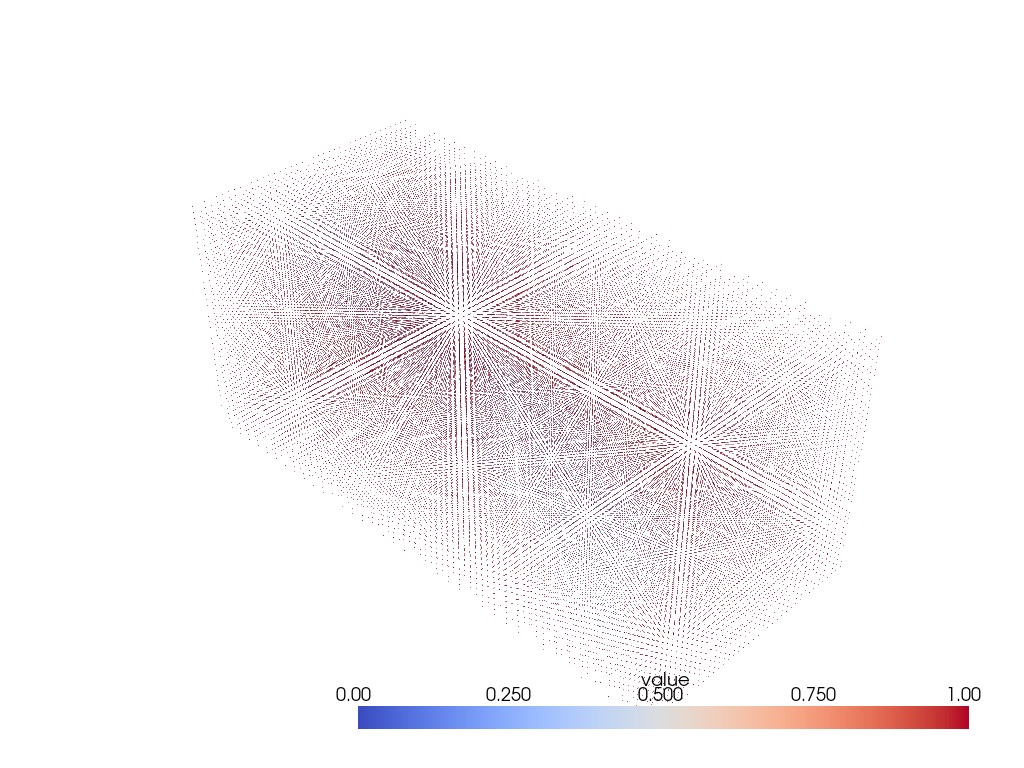

(raylet) [2024-07-22 19:41:05,565 E 41078 41078] (raylet) worker_pool.cc:565: Some workers of the worker process(44106) have not registered within the timeout. The process is dead, probably it crashed during start. [repeated 2x across cluster]


In [9]:
import numpy as np
import meshio
import trimesh
import ray
import pyvista as pv

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Load the STL file using meshio
mesh = meshio.read('/home/dave/Downloads/surface_cut.stl')

# Extract vertices and faces
vertices = mesh.points
faces = mesh.cells_dict['triangle']

# Convert the faces array to the format required by PyVista
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).flatten()

# Create a PyVista PolyData object from the vertices and faces
pv_mesh = pv.PolyData(vertices, faces_pv)

# Smooth the mesh
smoothed_mesh = pv_mesh.smooth(n_iter=30, relaxation_factor=0.1)

# Extract the smoothed vertices and faces
vertices = smoothed_mesh.points
faces = smoothed_mesh.faces.reshape(-1, 4)[:, 1:]

print(f"Original mesh: {mesh.points.shape[0]} vertices, {len(mesh.cells_dict['triangle'])} faces")

# Define the bounds of the grid
x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()

# Define the resolution of the grid
resolution = 40  # Reduce for faster testing

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
z = np.linspace(z_min, z_max, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

# Convert the mesh data to a trimesh object
tri_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Function to check points in chunks and assign values
@ray.remote
def check_points_chunk(chunk):
    inside = tri_mesh.contains(chunk)
    return np.where(inside, 0, 1)

# Split points into chunks for parallel processing
num_chunks = 8
chunks = np.array_split(points, num_chunks)

# Run the point-in-mesh check in parallel using Ray
futures = [check_points_chunk.remote(chunk) for chunk in chunks]
values_chunks = ray.get(futures)

# Combine the results
values = np.concatenate(values_chunks)

# Create the tensor of points and their values
tensor = np.hstack((points, values.reshape(-1, 1)))

# Reshape the inside array to the grid shape
grid_values = values.reshape((resolution, resolution, resolution))

# Create a PyVista StructuredGrid from the grid values
structured_grid = pv.StructuredGrid(xx, yy, zz)
structured_grid.point_data['value'] = grid_values.ravel()

# Save the StructuredGrid to a .vts file
structured_grid.save('grid_values.vtk')

# Save the tensor to different file formats
# CSV File
np.savetxt('points_with_values.csv', tensor, delimiter=',', header='x,y,z,value', comments='')

# TXT File
np.savetxt('points_with_values.txt', tensor, fmt='%.6f', header='x y z value', comments='')

# Binary NumPy File
np.save('points_with_values.npy', tensor)

# PyVista PLY File
point_cloud = pv.PolyData(points)
point_cloud.point_data['value'] = values
point_cloud.save('points_with_values.ply')

# Optional: Visualize with PyVista
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, scalars='value', cmap='coolwarm', point_size=1.0, render_points_as_spheres=True)
plotter.show()

ray.shutdown()
